# Exploratory Data Analysis (EDA) for Foodpanda Store in Hong Kong
Link to dataset: https://www.kaggle.com/datasets/bwandowando/hongkong-food-panda-restaurant-reviews

## 1. Introduction
This EDA aims to analyze the Foodpanda store and reviews datasets to uncover insights about customer preferences, restaurant performance, and overall satisfaction levels in the Hong Kong food market.

## Data description

### 1. Store Dataset

- **Content**: This dataset includes general information about the restaurant, such as:
    - **Restaurant Name**: The name of the restaurant.
    - **Food Type**: The type of cuisine offered (e.g., Chinese, Italian, Fast Food).
    - **Average Rating**: The average rating given to the restaurant.
    - **Review Count**: The total number of reviews received.
- **Purpose**: Analyzing this data helps to understand the current landscape of the food market in Hong Kong.

### 2. Reviews Dataset

- **Content**: This dataset includes detailed information about customer reviews, such as:
    - **Food Score**: Rating given specifically for the food.
    - **Overall Score**: General rating for the customer experience.
    - **Detailed Replies**: Customer comments and feedback.
- **Purpose**: This data helps to gauge customer satisfaction levels and identify areas for improvement in service and food quality.

**Data Loading**: Import the necessary libraries and load the datasets.

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from snownlp import SnowNLP
import jieba
jieba.set_dictionary('dict.txt.big')
jieba.initialize()
import jieba.posseg as seg


Building prefix dict from c:\Users\shuto\PersonalProjects\PersonalProjects\Python Project\foodpanda\dict.txt.big ...
Loading model from cache C:\Users\shuto\AppData\Local\Temp\jieba.u9249ca583064e542aedbd866cb12d9d7.cache
Loading model cost 1.911 seconds.
Prefix dict has been built successfully.


In [93]:
store = pd.read_excel("store.xlsx")
reviews = pd.read_excel("reviews.xlsx")

**Data Cleaning**: Address missing values and ensure data integrity.

In [94]:
store.isna().sum()

StoreId              0
CompleteStoreName    0
FoodType             0
AverageRating        0
Reviewers            0
City                 0
dtype: int64

In [95]:
len(reviews)

50548

In [96]:
# we have around 60% of our rider score is null, but it is not our focus part in the project, we would ignore it here.
reviews.isna().sum()

StoreId                0
uuid                   0
createdAt              0
updatedAt              0
text                   4
isAnonymous            0
reviewerId             0
replies                0
likeCount              0
isLiked                0
overall                0
restaurant_food        0
rider              33369
dtype: int64

In [97]:
# to be consistent casting all chinese name foodtype into english name
cuisine_mapping = {
    "台灣菜": "Taiwanese",
    "漢堡": "Burgers",
    "粵菜": "Chinese",
    "印度菜": "Italian",
    "中式": "Chinese",
    "薄餅": "Pizza",
    "日式": "Japanese",
    "國際佳餚": "International",
    "西班牙菜": "Spanish",
    "西式": "Western",
    "泰國菜": "Thai",
    "意大利菜": "Italian",
    "串燒": "Skewers",
    "丼飯": "Rice Bowl",
    "蛋糕": "Cakes",
    "美式": "American",
    "港式": "Hong Kong",
    "壽司": "Sushi"

}

# Function to replace Chinese names with English
def replace_food_name(food_name):
    return cuisine_mapping.get(food_name, food_name)  # Return the English name or the original if not found

# Apply the function to the food_name column
store['FoodType'] = store['FoodType'].apply(replace_food_name)

# rename of the store column
store.columns = ["store_id", "complete_store_name", "food_type", "average_rating", "reviewers_count", "city"]

# replace not valid food type (something mins, something 分鐘) to others
store.loc[store["food_type"].str.contains("分鐘| min"), "food_type"] = "others"

# cleanse reviewers_count column, removing bracket
store["reviewers_count"] = store["reviewers_count"].apply(lambda x: x.replace("(", "").replace(")", ""))

# cleanse store name, seperate the district name 
store[["store_name", "district"]] = store["complete_store_name"].str.split("(", expand= True)[[0,1]]
store["district"] = store["district"].str.replace(")", "")

# rename reviews column
reviews.columns = ["store_id", 
                   "user_id", 
                   "created_at", 
                   "updated_at", 
                   "reviews", 
                   "is_anonymous", 
                   "reviewers_id", 
                   "replies", 
                   "like_count", 
                   "is_like", 
                   "overall", 
                   "food_score", 
                   "rider_score"]
# updating created_at and updated_at into datetime format
reviews["created_at"] = pd.to_datetime(reviews["created_at"], unit='D', origin='1899-12-30')
reviews["updated_at"] = pd.to_datetime(reviews["updated_at"], unit='D', origin='1899-12-30')

reviews["created_at_month"] = reviews["created_at"].dt.month
reviews["created_at_day"] = reviews["created_at"].dt.day
reviews['created_at_weekday'] = reviews['created_at'].dt.day_name()
reviews["created_at_hour"] = reviews["created_at"].dt.hour


**Exploratory Analysis**: Execute visualizations and statistical calculations to answer the questions below.

### Store Dataset
1. **Unique Stores and Food Types**
   - How many unique stores and distinct food types are present in the dataset?
   

In [99]:
# there is 6117 unique restaurant in foodpanda
len(store["store_name"].unique())

6117

In [100]:
# there is 73 distinct foodtype 
len(store["food_type"].unique())

72

2. **Rating Analysis**
   - What is the average rating by food type, which food type has the highest average rating and the lowest average rating?
   - How many stores have a perfect score of 5?

In [101]:
avg_rating_by_foodtype = store.groupby("food_type")["average_rating"].mean()
top_10 = avg_rating_by_foodtype.sort_values(ascending = False).head(10)
worst_10 = avg_rating_by_foodtype.sort_values(ascending = True).head(10) 

In [102]:
top_10

food_type
Healthy          5.000000
Snacks           4.800000
Salad            4.700000
Filipino         4.657143
Mediterranean    4.650000
Ice Cream        4.650000
Vegetarian       4.650000
German           4.600000
Drinks           4.600000
Fried Chicken    4.518519
Name: average_rating, dtype: float64

In [103]:
worst_10

food_type
Udon         3.100000
Soups        3.300000
Bakery       3.350000
Noodles      3.600000
Sandwich     3.700000
Malaysian    3.884211
Curry        3.896970
Dessert      3.916667
Kebab        4.000000
Chiu Chow    4.014286
Name: average_rating, dtype: float64

In [104]:
# there is 250 reviews gives a score of 5
len(store[store["average_rating"] == 5.0])

250

In [105]:
# out of the 250 reviews giving a score of 5, around 20% is hong knog style food, 15% is western style food, 8% is Japanese food
store[store["average_rating"] == 5.0].groupby("food_type")["store_id"].count().sort_values(ascending = False).head(5)

food_type
Hong Kong        44
Western          37
Japanese         19
Chinese          13
International    12
Name: store_id, dtype: int64

3. **Commonality Insights**
   - What is the most common food type and store in the dataset?
   - Are there any restaurants that have both high ratings and a high number of reviews?

In [106]:
store_name_count = store.groupby("store_name")["store_id"].count()
store_name_count.sort_values(ascending= False).head(5)

store_name
Hau Xing Yu Shredded Chicken     9
Chung Kee Dessert                5
Eat Together                     4
Thai Food                        4
Fook Hing Restaurant             3
Name: store_id, dtype: int64

In [107]:
# Function to convert review counts to numeric
def convert_review_count(count):
    if isinstance(count, str):  # Check if count is a string
        # Remove unwanted characters such as parentheses and plus signs
        count = count.replace('(', '').replace(')', '').replace('+', '')
        # Convert to integer
        return int(count) + 1 if count.isdigit() else None  # Add 1 for the upper bound if it's numeric
    return None  # Return None if it's not a string

# Apply the conversion function
store['reviewers_count'] = store['reviewers_count'].apply(convert_review_count)

# Define the bins and labels
bins = [0, 20, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, float('inf')]
labels = ['1-20', '20-50', '50-100', '100-500', '500-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000+']

# Create a new column for the review groups
store['reviewers_group'] = pd.cut(store['reviewers_count'] , bins=bins, labels=labels, right=False)

# Count the number of stores in each review group
grouped_counts = store['reviewers_group'].value_counts().sort_index()



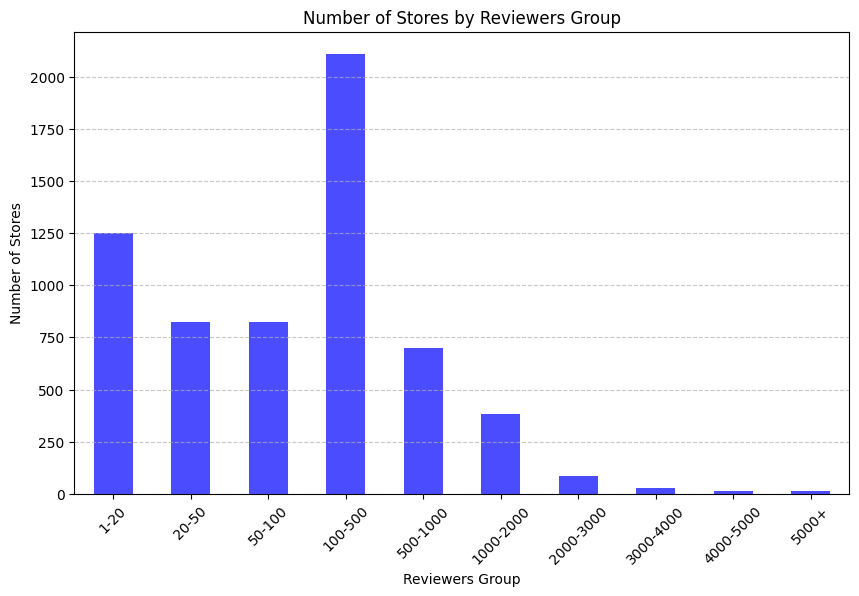

In [108]:
plt.figure(figsize=(10, 6))
grouped_counts.plot(kind='bar', color='b', alpha=0.7)
plt.title('Number of Stores by Reviewers Group')
plt.xlabel('Reviewers Group')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()

The bar plot illustrates the distribution of the number of stores across different reviewers groups. Notably, the group with 100-500 reviews has the highest count, exceeding 2,000 stores. This indicates that the majority of food stores fall within this review range.

Furthermore, the count of stores in the 100-500 reviews group is nearly double that of the second highest group, which is the 1-20 reviews range. 

C:\Users\shuto\AppData\Local\Temp\ipykernel_50464\1519284655.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='reviewers_group', y='average_rating', data=store, order=category_order, palette='Set2')
C:\Users\shuto\AppData\Local\Temp\ipykernel_50464\1519284655.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Data Points', loc='upper right')  # Optional legend


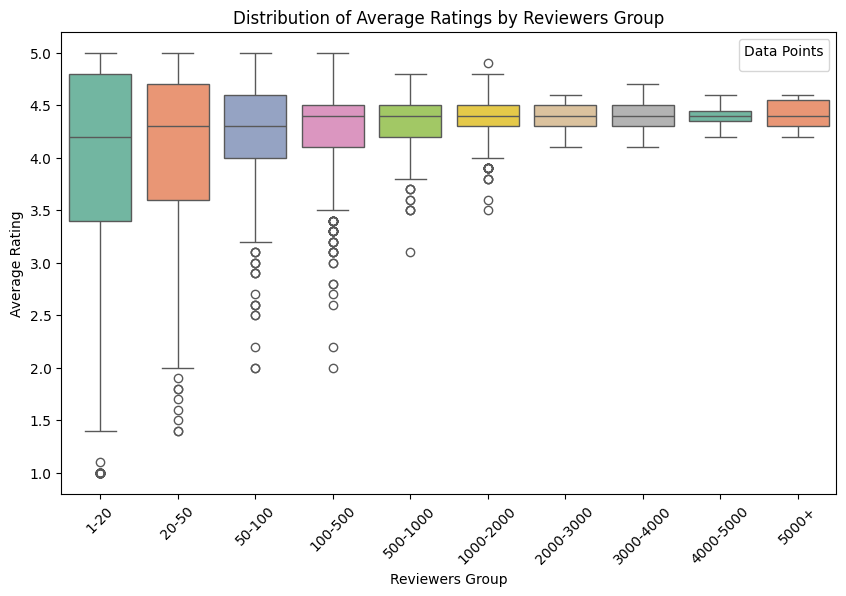

In [109]:
category_order = ['1-20', '20-50', '50-100', '100-500', '500-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000+']
store["reviewers_group"] = pd.Categorical(store['reviewers_group'], categories=category_order, ordered=True)

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='reviewers_group', y='average_rating', data=store, order=category_order, palette='Set2')
plt.title('Distribution of Average Ratings by Reviewers Group')
plt.xlabel('Reviewers Group')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.legend(title='Data Points', loc='upper right')  # Optional legend
plt.show()

The box plot illustrates the distribution of average ratings across different reviewers groups.
- In terms of medican, the median average ratings across all reviewers groups are relatively consistent, indicating that the central tendency of ratings does not vary significantly among groups.
- Regarding the interquartile range, Q1 and Q3 becomes narrower as the reviewers group increases. This suggests that as the number of reviewers grows, the variability in average ratings decreases, leading to more consensus on ratings.
- In terms of outliers, there are fewer outliers in the higher reviewers groups compared to the lower ones. This indicates that stores with a larger number of reviews tend to have ratings that are more aligned with the overall median, whereas those with fewer reviews exhibit a wider spread of ratings.

### Reviews Dataset
1. **Temporal Analysis**
   - Is there a specific time frame when users are more likely to leave comments

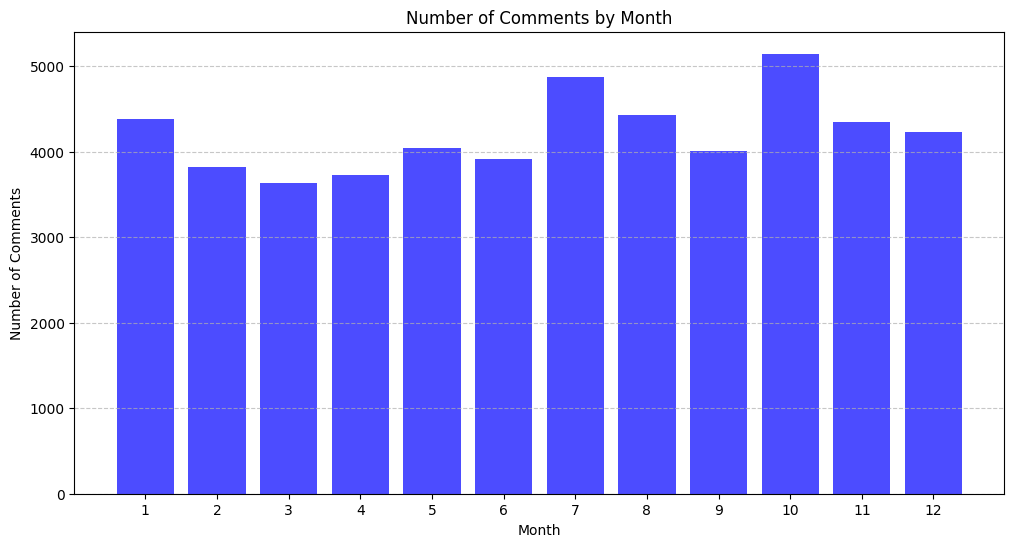

In [113]:
# Count the number of comments per hour
monthly_counts = reviews['created_at_month'].value_counts().sort_index()

# Create a bar plot for the counts of comments by month
plt.figure(figsize=(12, 6))
plt.bar(monthly_counts.index.astype(str), monthly_counts.values, color='b', alpha=0.7)
plt.title('Number of Comments by Month')
plt.xlabel('Month')
plt.ylabel('Number of Comments')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()

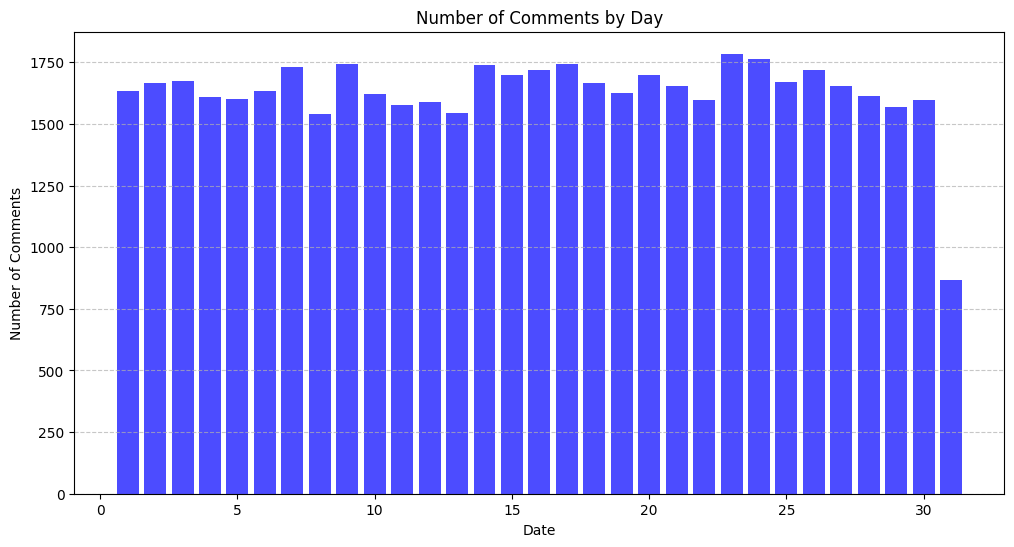

In [115]:
# Count the number of comments per day
daily_counts = reviews['created_at_day'].value_counts().sort_index()

# Create a bar plot for the counts of comments by day
plt.figure(figsize=(12, 6))
plt.bar(daily_counts.index, daily_counts.values, color='b', alpha=0.7)
plt.title('Number of Comments by Day')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()

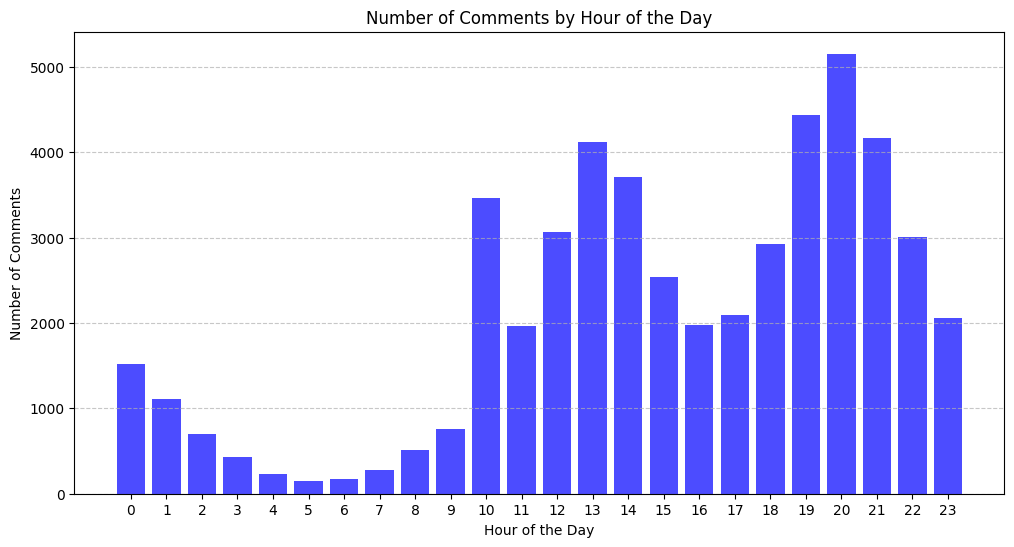

In [110]:
# Count the number of comments per hour
hourly_counts = reviews['created_at_hour'].value_counts().sort_index()

# Create a bar plot for the counts of comments by hour
plt.figure(figsize=(12, 6))
plt.bar(hourly_counts.index, hourly_counts.values, color='b', alpha=0.7)
plt.title('Number of Comments by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Comments')
plt.xticks(hourly_counts.index)  # Ensure all hour ticks are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()

The monthly graph indicates that July and October receive a slightly higher number of comments compared to other months. In terms of the days, throughout the year, the 31st appears less ubiquitously than other days, resulting in a lower overall number of comments on those dates.

Looking at the hourly graph, the majority of comments are concentrated between 10:00 AM and 11:00 AM, as well as between 1:00 PM and 2:00 PM, and from 7:00 PM to 9:00 PM. This pattern aligns with typical meal times, suggesting that users are more likely to leave comments shortly after eating.

2. **Sentiment vs. Rating**
   - What is the correlation between sentiment scores and overall ratings?

In [117]:
def get_sentiment(text):
    if isinstance(text, str):
        s = SnowNLP(text)
        return s.sentiments  # Sentiment score
    else:
        return None 
    
# Define a dictionary for word adjustments
WORD_ADJUSTMENTS = {
    "好食": 0.1,
    "超正": 0.1,
    "好味": 0.1,
    "讚": 0.1,
    "抵食":0.1,
    "不錯": 0.1,
    "難食": -0.1,
    "不好食": -0.1,
    "冇味": -0.1,
    "難飲": -0.1,
    "不满意": -0.1,
    "差": -0.1,
    "不建議": -0.1,
    "壞": -0.1,
    "難吃": -0.1,
    "好難食": -0.2
    
    # Add more words and their adjustments as needed
}
def adjust_sentiment_score(word, score):
    # Adjust sentiment score based on the defined dictionary
    if word in WORD_ADJUSTMENTS:
        adjustment = WORD_ADJUSTMENTS[word]
        return min(max(score + adjustment, 0.0), 1.0)  # Ensure score stays between 0 and 1
    return score

def sentiment_analysis(text):
    if isinstance(text, str):
        words = [word for word in jieba.cut(text)]
        pos_num = 0
        neg_num = 0
        
        # Analyze sentiment for each word
        for word in words:
            sl = SnowNLP(word)
            adjusted_score = adjust_sentiment_score(word, sl.sentiments)
            if adjusted_score > 0.5:
                pos_num += 1
            else:
                neg_num += 1

        pos_percentage = pos_num / (pos_num + neg_num) if (pos_num + neg_num) > 0 else 0
        return pos_percentage
    else:
        return None  

In [120]:
reviews["snownlp_sentiment_score"] = reviews["reviews"].apply(get_sentiment)

In [121]:
reviews["own_sentiment_score"] = reviews["reviews"].apply(sentiment_analysis)


Correlation between overall and own_sentiment_score: 0.22699359114374693


C:\Users\shuto\AppData\Local\Temp\ipykernel_50464\636045375.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall', y='own_sentiment_score', data=reviews, palette='Blues')


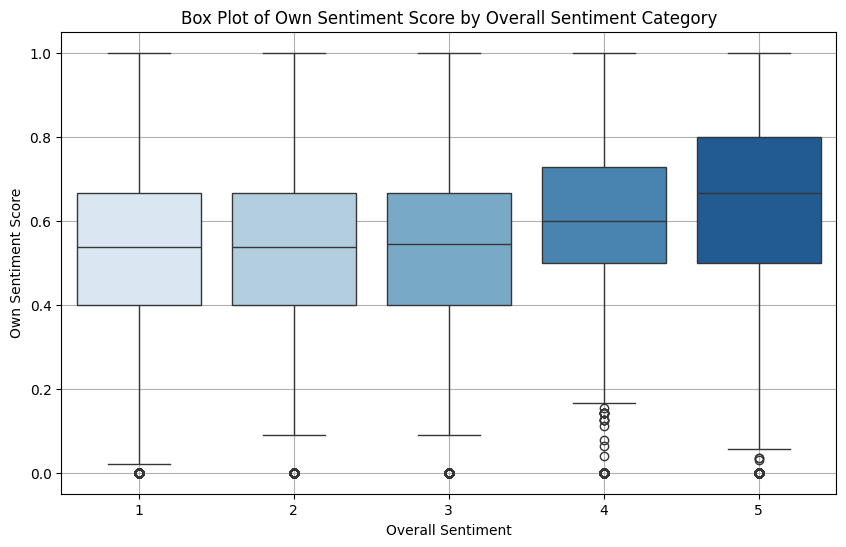

In [124]:
# Calculate the correlation between 'overall' and 'own_sentiment_score'
correlation = reviews['overall'].corr(reviews['own_sentiment_score'])
print(f'Correlation between overall and own_sentiment_score: {correlation}')

# Create a box plot to visualize the distribution of own_sentiment_score for each overall category
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='own_sentiment_score', data=reviews, palette='Blues')
plt.title('Box Plot of Own Sentiment Score by Overall Sentiment Category')
plt.xlabel('Overall Sentiment')
plt.ylabel('Own Sentiment Score')
plt.grid(True)
plt.show()

Correlation between overall and snownlp_sentiment_score: 0.21030892556171263


C:\Users\shuto\AppData\Local\Temp\ipykernel_50464\4117598638.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall', y='snownlp_sentiment_score', data=reviews, palette='Blues')


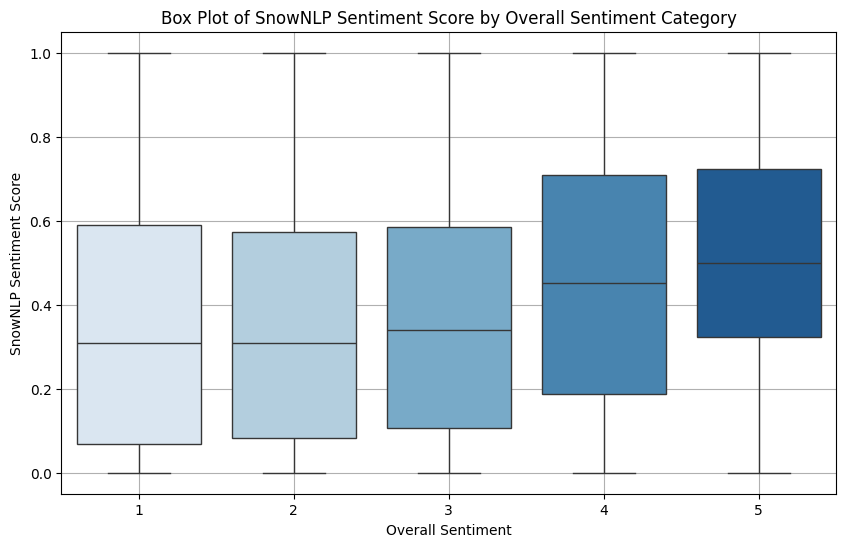

In [125]:
# Calculate the correlation between 'overall' and 'snownlp_sentiment_score'
correlation = reviews['overall'].corr(reviews['snownlp_sentiment_score'])
print(f'Correlation between overall and snownlp_sentiment_score: {correlation}')

# Create a box plot to visualize the distribution of snownlp_sentiment_score for each overall category
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='snownlp_sentiment_score', data=reviews, palette='Blues')
plt.title('Box Plot of SnowNLP Sentiment Score by Overall Sentiment Category')
plt.xlabel('Overall Sentiment')
plt.ylabel('SnowNLP Sentiment Score')
plt.grid(True)
plt.show()

The correlation between overall and own_sentiment_score or snownlp_sentiment_score is relatively low at 0.2. This can be attributed to several challenges in processing Cantonese NLP. Different types of food have varying textures, which complicates the sentiment analysis—hard textures may be perceived as good in some contexts, while tenderness is preferred in others. Additionally, the temperature of food (hot versus cold) plays a significant role in customer satisfaction.

When both positive and negative aspects are present in comments, it becomes difficult to derive a clear sentiment score. The use of local Cantonese slang, such as "CP值爆燈" or "唔好食," further complicates sentiment analysis, as capturing these phrases accurately in a dictionary requires more time and effort.

Moreover, some pre-adjustment sentiment scores do not align with reasonable expectations. For instance, the phrase "好難食" receives a score of 0.63, while "難食" scores 0.5, which does not accurately reflect their negative connotations.